# TinyGRU VAD - Ground Truth Labeling & Prediction

This notebook demonstrates:
1. **Ground Truth Labeling**: Generate VAD labels from clean speech using energy-based thresholding
2. **TinyGRU VAD Prediction**: Load trained model and generate predictions
3. **Visualization**: Plot ground truth vs predictions with audio waveforms and spectrograms

In [56]:
# %% ------------------------- Imports & Setup ------------------------
import sys
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Setup paths
current_dir = Path.cwd()
repo_root = current_dir.parent.parent
sys.path.insert(0, str(repo_root / "src"))

print("Repo root:", repo_root)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Import utilities
from utils.audio_dataset_loader import (
    load_ears_dataset, load_wham_dataset, 
    create_audio_pairs, preprocess_audio
)

Repo root: c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85
Using device: cpu


In [57]:
# %% ------------------------- Global Plot Settings -------------------------
plt.rcParams['figure.dpi'] = 400
plt.rcParams['font.size'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18

print("[INFO] Global plot settings applied: DPI=400")

[INFO] Global plot settings applied: DPI=400


In [58]:
# %% ------------------------- TinyGRU VAD Model -------------------------
class TinyGRUVAD(nn.Module):
    """Light GRU-based VAD, causal, hearing-aid friendly (~3.5k params with 24 mel bands)."""
    def __init__(self, input_dim=48, hidden_dim=16, dropout=0.1):
        super().__init__()
        
        self.pre = nn.Conv1d(input_dim, input_dim, kernel_size=3, padding=0, groups=input_dim)
        self.norm = nn.LayerNorm(input_dim)
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, h=None):
        # x: (B,T,F)
        x = x.transpose(1,2)              # (B,F,T)
        # causal pad: pad (kernel_size-1) frames on the left only
        k = self.pre.kernel_size[0] if isinstance(self.pre.kernel_size, (list, tuple)) else self.pre.kernel_size
        pad_left = k - 1
        x = F.pad(x, (pad_left, 0))       # pad on time dimension
        x = self.pre(x).transpose(1,2)    # local causal conv
        x = self.norm(x)
        out, h = self.gru(x, h)
        out = self.drop(out)
        # return raw logits (B,T,1)
        logits = self.fc(out)
        return logits, h

print("[INFO] TinyGRU VAD model defined")

[INFO] TinyGRU VAD model defined


In [59]:
# %% ------------------------- Ground Truth Labeling Function -------------------------
def simple_energy_vad_labels(clean_wave, fs, frame_len=0.008, hop_len=0.004, 
                             energy_percentile=0.40, min_speech_frames=3):
    """Generate VAD labels directly from CLEAN signal energy.
    
    GOLD STANDARD for supervised VAD training with anechoic recordings:
    1. Compute frame-wise energy of clean speech
    2. Set threshold at percentile of energy distribution
    3. Frames above threshold = SPEECH, below = SILENCE
    
    Args:
        clean_wave: Clean speech signal from anechoic chamber
        fs: Sample rate
        frame_len: Frame length in seconds (default: 8ms)
        hop_len: Hop length in seconds (default: 4ms)
        energy_percentile: Percentile for threshold (0.40 = 40th percentile)
        min_speech_frames: Minimum consecutive frames to count as speech
    
    Returns:
        Binary VAD labels (T, 1) tensor
    """
    n_fft, hop = int(fs * frame_len), int(fs * hop_len)
    
    # Compute frame-wise energy
    frame_energy = []
    for i in range(0, len(clean_wave) - n_fft, hop):
        frame = clean_wave[i:i + n_fft]
        energy = (frame ** 2).mean()  # RMS energy
        frame_energy.append(energy)
    
    frame_energy = torch.tensor(frame_energy)
    
    # Set threshold based on energy distribution
    sorted_energy = torch.sort(frame_energy)[0]
    threshold_idx = int(energy_percentile * len(sorted_energy))
    energy_threshold = sorted_energy[threshold_idx]
    
    # Initial speech detection
    speech_frames = (frame_energy > energy_threshold).float()
    
    # Temporal smoothing: Remove isolated short segments
    if min_speech_frames > 1:
        smoothed = speech_frames.clone()
        i = 0
        while i < len(speech_frames):
            if speech_frames[i] == 1:
                start = i
                end = i
                while end < len(speech_frames) and speech_frames[end] == 1:
                    end += 1
                duration = end - start
                
                if duration < min_speech_frames:
                    smoothed[start:end] = 0
                
                i = end
            else:
                i += 1
    else:
        smoothed = speech_frames
    
    return smoothed.unsqueeze(1)

print("[INFO] Ground truth labeling function defined")

[INFO] Ground truth labeling function defined


In [60]:
# %% ------------------------- Feature Extraction -------------------------
def mix_and_extract(noisy_wave, clean_wave, fs, n_bands=24, frame_len=0.008, hop_len=0.004):
    """Extract log-mel + delta features from noisy audio with VAD labels from clean speech.
    
    Args:
        noisy_wave: Noisy input signal
        clean_wave: Clean reference signal (for ground truth labels)
        fs: Sample rate (typically 16000 Hz)
        n_bands: Number of mel bands (default: 24)
        frame_len: Frame length in seconds (default: 0.008 = 8ms)
        hop_len: Hop length in seconds (default: 0.004 = 4ms)
    
    Returns:
        feats: (1, T, 2*n_bands) feature tensor
        labels: (1, T, 1) binary label tensor
    """
    # Convert to mono
    if noisy_wave.dim() > 1 and noisy_wave.shape[0] > 1:
        noisy_wave = noisy_wave.mean(dim=0)
    elif noisy_wave.dim() > 1:
        noisy_wave = noisy_wave[0]
    
    if clean_wave.dim() > 1 and clean_wave.shape[0] > 1:
        clean_wave = clean_wave.mean(dim=0)
    elif clean_wave.dim() > 1:
        clean_wave = clean_wave[0]
    
    # Ensure same length
    max_len = max(noisy_wave.shape[0], clean_wave.shape[0])
    if noisy_wave.shape[0] < max_len:
        noisy_wave = F.pad(noisy_wave, (0, max_len - noisy_wave.shape[0]))
    if clean_wave.shape[0] < max_len:
        clean_wave = F.pad(clean_wave, (0, max_len - clean_wave.shape[0]))
    
    n_fft, hop = int(fs*frame_len), int(fs*hop_len)
    win = torch.hann_window(n_fft)

    def pspec(w): 
        spec = torch.stft(w, n_fft, hop, window=win, center=False, return_complex=True)
        return spec.abs()**2

    mel = torchaudio.transforms.MelScale(n_mels=n_bands, sample_rate=fs, n_stft=n_fft//2+1)
    
    # Extract features from NOISY audio
    melN = mel(pspec(noisy_wave)).clamp_min(1e-8)
    logN = torch.log(melN.T + 1e-8)
    delta = torch.zeros_like(logN)
    delta[1:] = logN[1:] - logN[:-1]
    feats = torch.cat([logN, delta], 1).unsqueeze(0)
    
    # Generate labels from CLEAN speech
    labels = simple_energy_vad_labels(clean_wave, fs, frame_len, hop_len, 
                                     energy_percentile=0.40, min_speech_frames=3)
    
    if labels.dim() == 2:
        labels = labels.unsqueeze(0)
    
    # Ensure same temporal dimension
    min_frames = min(feats.size(1), labels.size(1))
    feats = feats[:, :min_frames, :]
    labels = labels[:, :min_frames, :]
    
    return feats, labels

print("[INFO] Feature extraction function defined")

[INFO] Feature extraction function defined


In [61]:
# %% ------------------------- Load Trained Model -------------------------
# Load best model
model_path = repo_root / "models" / "GRU_VAD" / "tiny_vad_best.pth"

if not model_path.exists():
    print(f"[ERROR] Model not found at: {model_path}")
    print("[INFO] Please train the model first using TinyGruVAD_Training.ipynb")
else:
    vad = TinyGRUVAD(input_dim=48, hidden_dim=16, dropout=0.0)
    vad.load_state_dict(torch.load(model_path, map_location=device))
    vad = vad.to(device)
    vad.eval()
    print(f"[INFO] Loaded model from: {model_path}")
    
    # Model info
    total_params = sum(p.numel() for p in vad.parameters())
    print(f"[INFO] Total parameters: {total_params:,}")

[INFO] Loaded model from: c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85\models\GRU_VAD\tiny_vad_best.pth
[INFO] Total parameters: 3,473


In [62]:
# %% ------------------------- Load Test Data -------------------------
# Load test set
noise_test = load_wham_dataset(repo_root, mode="test", max_files=10)
clean_test = load_ears_dataset(repo_root, mode="test")
test_pairs = create_audio_pairs(noise_test, clean_test)

print(f"[INFO] Loaded {len(test_pairs)} test pairs")

Limited WHAM dataset to 10 files for test mode


c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85\src\utils\audio_dataset_loader.py:62: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  info = torchaudio.info(f)
c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85\.venv\Lib\site-packages\torchaudio\_backend\soundfile_backend.py:120: UserWarning: torchaudio._backend.common.AudioMetaData has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCod

Created 10 audio pairs
[INFO] Loaded 10 test pairs


In [63]:
# %% ------------------------- Generate Predictions -------------------------
# Select a test sample
test_idx = 0
noise_file, clean_file = test_pairs[test_idx]

print(f"[INFO] Processing test sample {test_idx}")
print(f"  Clean: {Path(clean_file).name}")
print(f"  Noise: {Path(noise_file).name}")

# Process audio at different SNRs
snr_db = 0  # Change this to test different SNR levels

clean_wave, noise_wave, noisy_wave, fs = preprocess_audio(
    Path(clean_file), Path(noise_file), 
    target_sr=16000, snr_db=snr_db
)

# Extract features and ground truth labels
feats, labels = mix_and_extract(noisy_wave, clean_wave, fs, n_bands=24)

print(f"[INFO] Features shape: {feats.shape}")
print(f"[INFO] Labels shape: {labels.shape}")
print(f"[INFO] Audio length: {len(clean_wave) / fs:.2f} seconds")

# Generate predictions
with torch.no_grad():
    logits, _ = vad(feats.to(device))
    predictions = torch.sigmoid(logits).squeeze().cpu().numpy()

labels_np = labels.squeeze().cpu().numpy()

print(f"[INFO] Predictions shape: {predictions.shape}")
print(f"[INFO] Prediction range: [{predictions.min():.3f}, {predictions.max():.3f}]")

[INFO] Processing test sample 0
  Clean: emo_adoration_freeform.wav
  Noise: 445c020a_0.25797_444c0212_-0.25797.wav
Clean speech duration: 15.57s (249096 samples)
Noise duration: 12.07s (193094 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades


c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85\.venv\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


[INFO] Features shape: torch.Size([1, 3891, 48])
[INFO] Labels shape: torch.Size([1, 3891, 1])
[INFO] Audio length: 0.00 seconds
[INFO] Predictions shape: (3891,)
[INFO] Prediction range: [0.275, 0.934]



[INFO] Figure saved to: c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85\results\GRU_VAD\predictions\vad_prediction_sample_0_snr_0dB.png


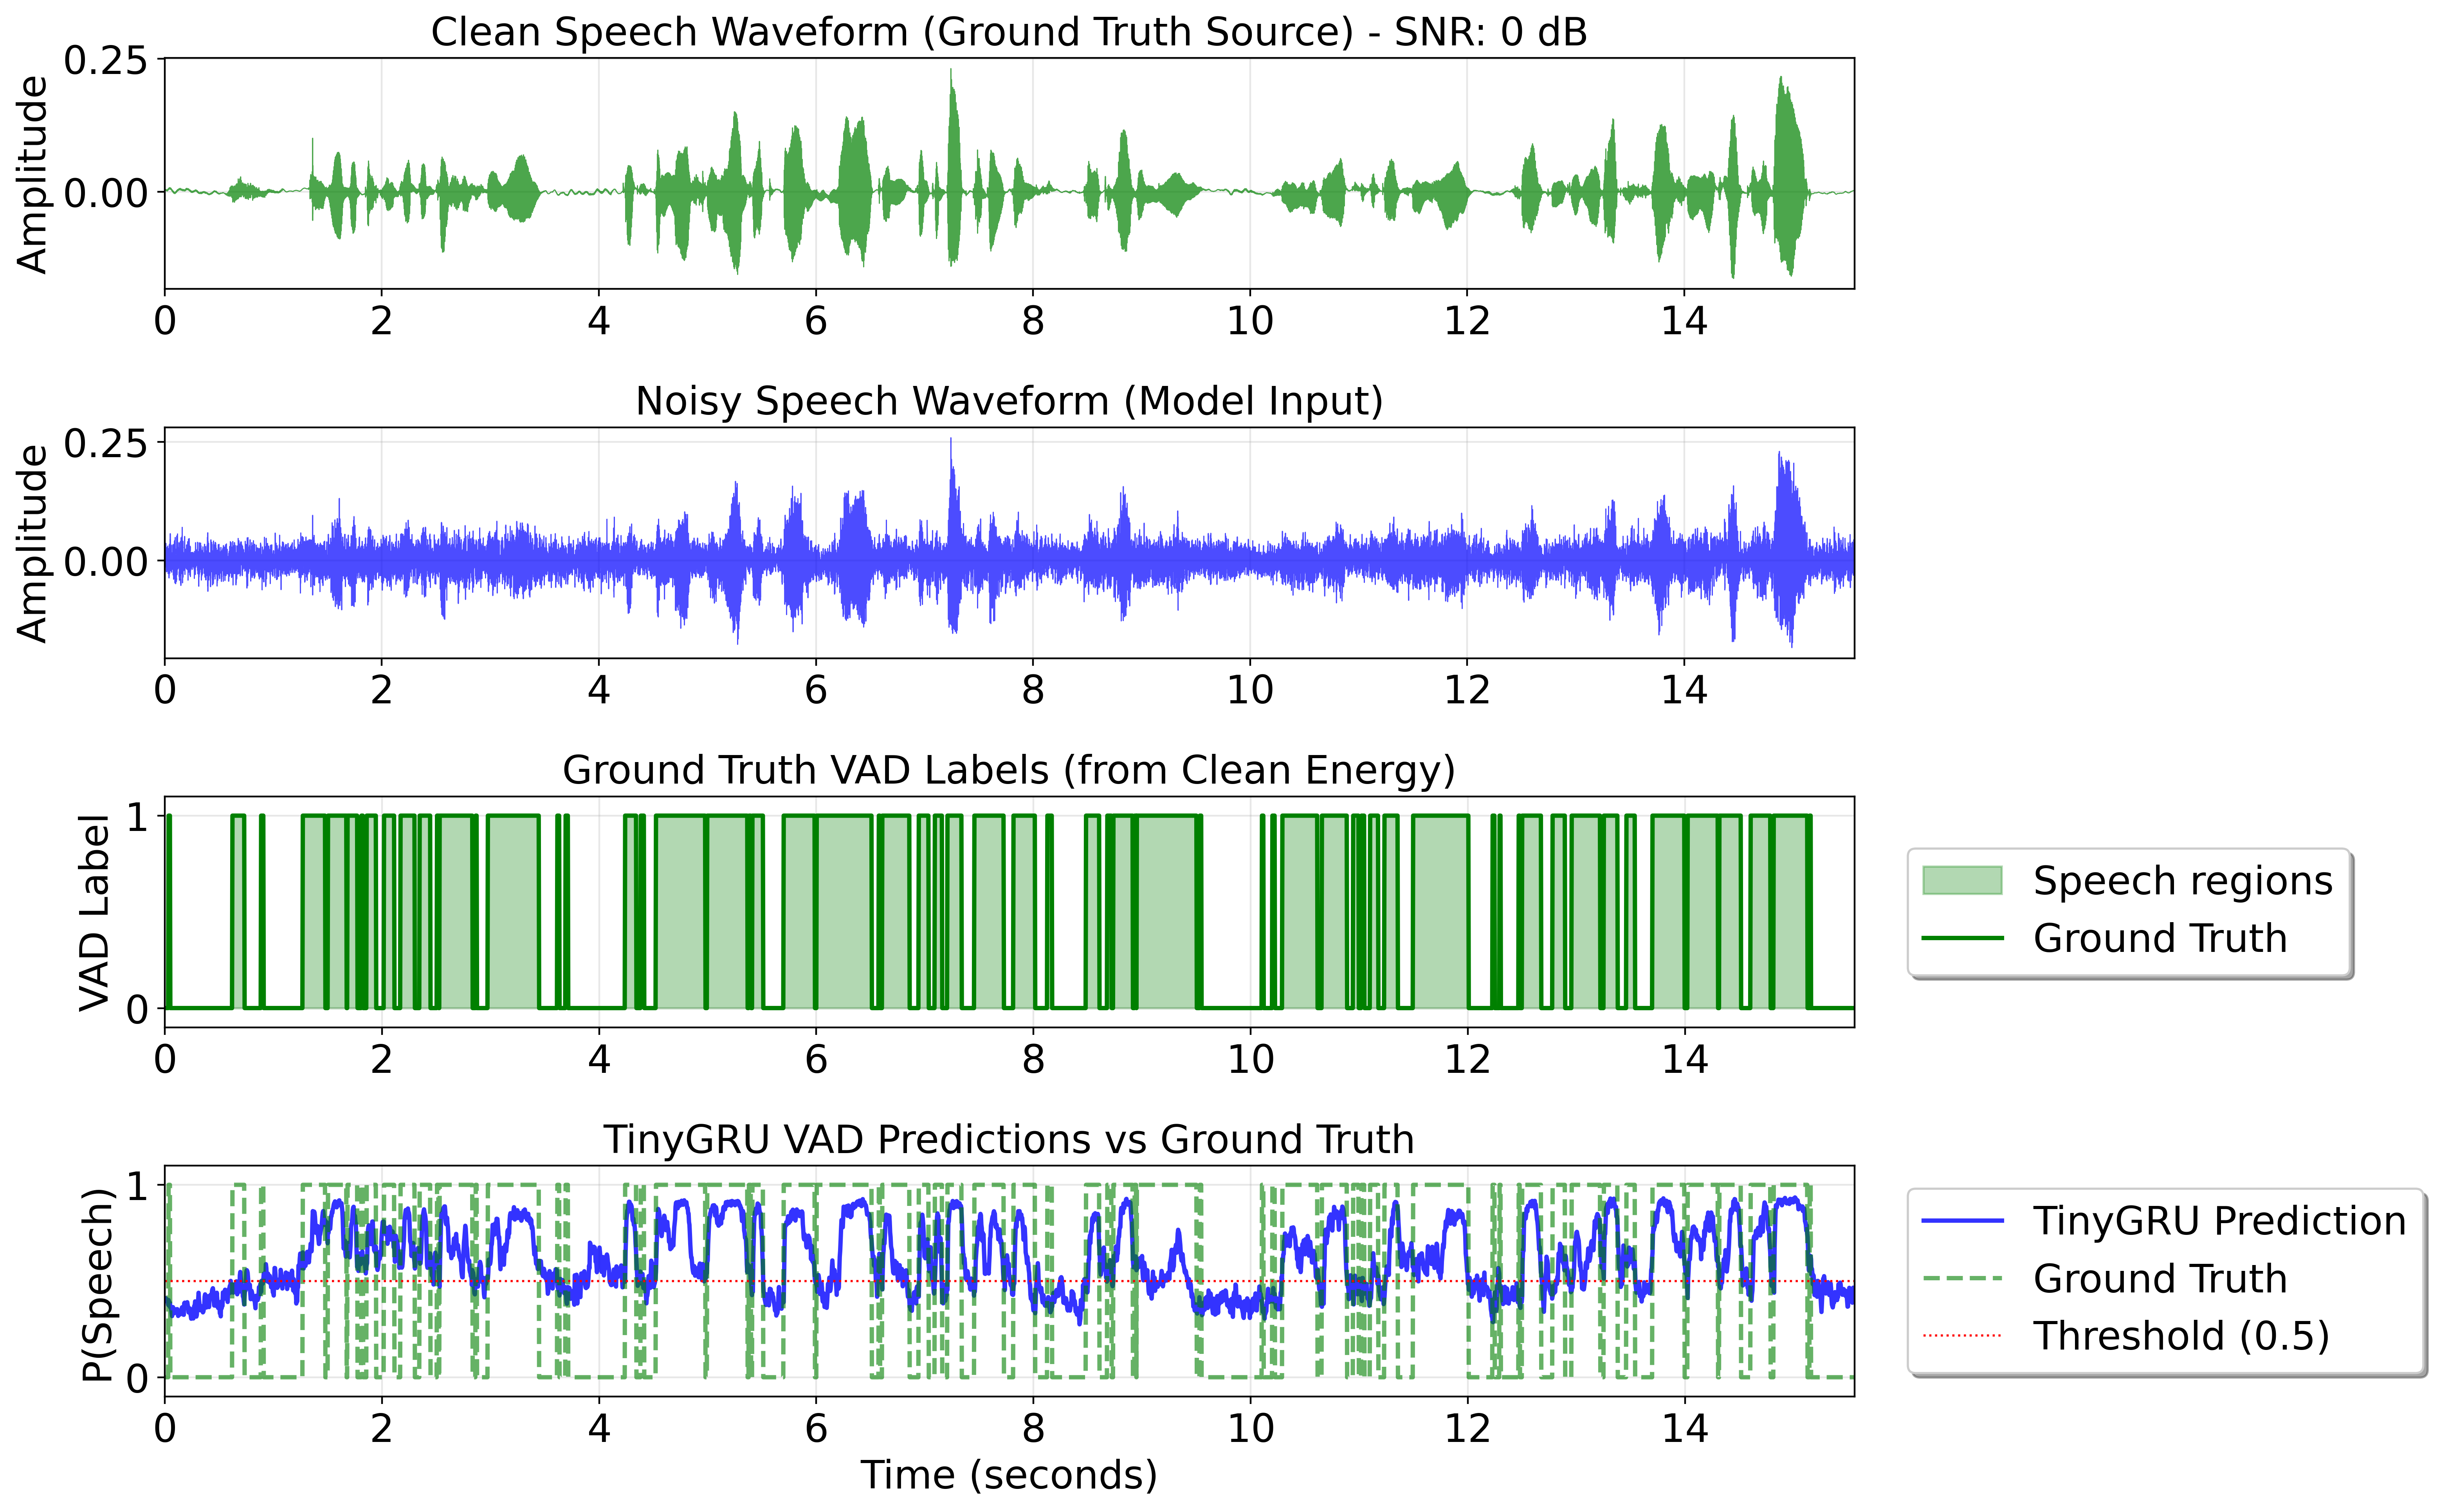

In [68]:
# %% ------------------------- Plotting Results -------------------------
fig, axes = plt.subplots(4, 1, figsize=(16, 10))

# Ensure waveforms are 1D for plotting
clean_wave_plot = clean_wave.squeeze() if clean_wave.dim() > 1 else clean_wave
noisy_wave_plot = noisy_wave.squeeze() if noisy_wave.dim() > 1 else noisy_wave

# Time axis (in seconds)
time_frames = np.arange(len(predictions)) * 0.004  # 4ms hop
time_samples = np.arange(len(clean_wave_plot)) / fs

# Plot 1: Clean waveform
ax1 = axes[0]
ax1.plot(time_samples, clean_wave_plot.numpy(), 'g-', linewidth=0.5, alpha=0.7)
ax1.set_ylabel('Amplitude')
ax1.set_title(f'Clean Speech Waveform (Ground Truth Source) - SNR: {snr_db} dB')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, time_samples[-1]])

# Plot 2: Noisy waveform
ax2 = axes[1]
ax2.plot(time_samples, noisy_wave_plot.numpy(), 'b-', linewidth=0.5, alpha=0.7)
ax2.set_ylabel('Amplitude')
ax2.set_title('Noisy Speech Waveform (Model Input)')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, time_samples[-1]])

# Plot 3: Ground truth VAD labels
ax3 = axes[2]
ax3.fill_between(time_frames, 0, labels_np, color='green', alpha=0.3, label='Speech regions')
ax3.plot(time_frames, labels_np, 'g-', linewidth=2, label='Ground Truth')
ax3.set_ylabel('VAD Label')
ax3.set_title('Ground Truth VAD Labels (from Clean Energy)')
ax3.set_ylim([-0.1, 1.1])
ax3.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True, fancybox=True, shadow=True)
ax3.grid(True, alpha=0.3)
ax3.set_xlim([0, time_frames[-1]])

# Plot 4: TinyGRU predictions vs ground truth
ax4 = axes[3]
ax4.plot(time_frames, predictions, 'b-', linewidth=2, label='TinyGRU Prediction', alpha=0.8)
ax4.plot(time_frames, labels_np, 'g--', linewidth=2, label='Ground Truth', alpha=0.6)
ax4.axhline(y=0.5, color='r', linestyle=':', linewidth=1, label='Threshold (0.5)')
ax4.set_xlabel('Time (seconds)')
ax4.set_ylabel('P(Speech)')
ax4.set_title('TinyGRU VAD Predictions vs Ground Truth')
ax4.set_ylim([-0.1, 1.1])
ax4.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True, fancybox=True, shadow=True)
ax4.grid(True, alpha=0.3)
ax4.set_xlim([0, time_frames[-1]])

plt.tight_layout()

# Save figure
output_dir = repo_root / "results" / "GRU_VAD" / "predictions"
output_dir.mkdir(parents=True, exist_ok=True)
output_path = output_dir / f"vad_prediction_sample_{test_idx}_snr_{snr_db}dB.png"
fig.savefig(output_path, dpi=400, bbox_inches='tight')
print(f"\n[INFO] Figure saved to: {output_path}")

plt.show()

[INFO] Spectrogram saved to: c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85\results\GRU_VAD\predictions\vad_spectrogram_sample_0_snr_0dB.png


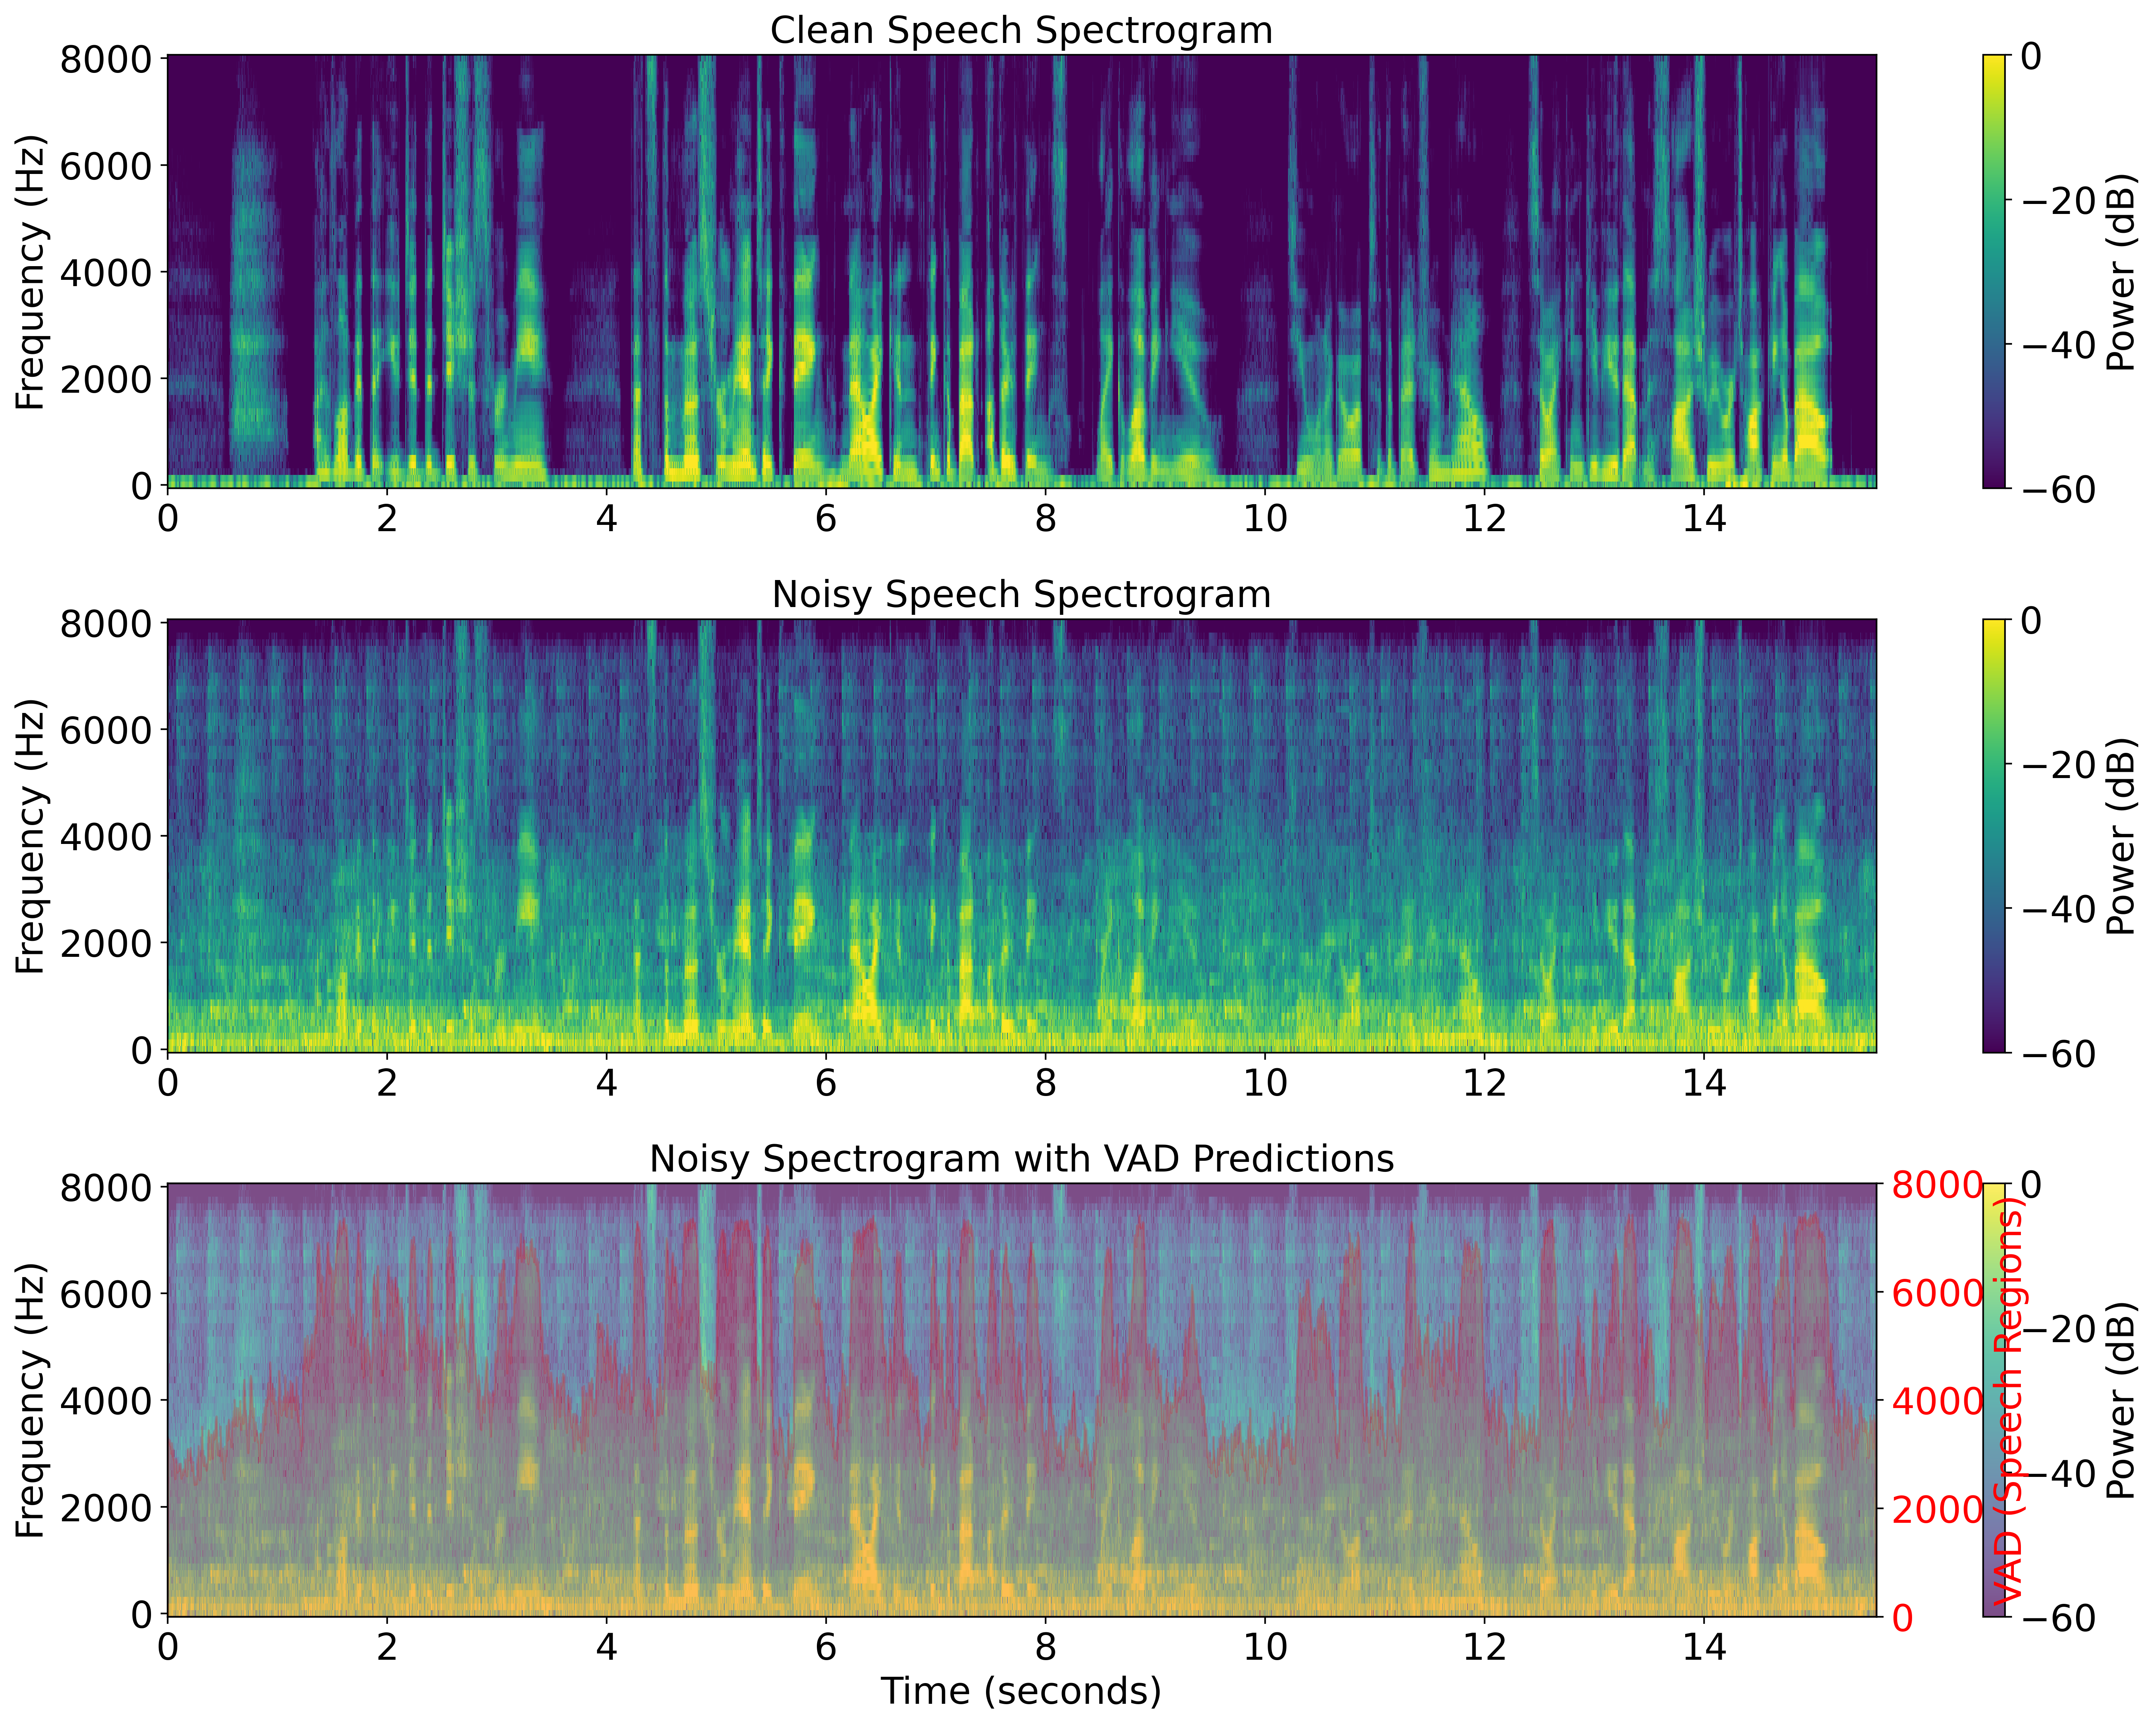

In [65]:
# %% ------------------------- Spectrogram Comparison -------------------------
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Ensure waveforms are properly shaped for spectrogram
clean_wave_spec = clean_wave_plot if 'clean_wave_plot' in locals() else clean_wave.squeeze()
noisy_wave_spec = noisy_wave_plot if 'noisy_wave_plot' in locals() else noisy_wave.squeeze()

# Compute spectrograms
n_fft = int(fs * 0.008)  # 8ms frame
hop_length = int(fs * 0.004)  # 4ms hop

# Clean spectrogram
spec_clean = torchaudio.transforms.Spectrogram(
    n_fft=n_fft, hop_length=hop_length, power=2.0
)(clean_wave_spec.unsqueeze(0) if clean_wave_spec.dim() == 1 else clean_wave_spec)
spec_clean_db = 10 * torch.log10(spec_clean.squeeze() + 1e-10)

# Noisy spectrogram
spec_noisy = torchaudio.transforms.Spectrogram(
    n_fft=n_fft, hop_length=hop_length, power=2.0
)(noisy_wave_spec.unsqueeze(0) if noisy_wave_spec.dim() == 1 else noisy_wave_spec)
spec_noisy_db = 10 * torch.log10(spec_noisy.squeeze() + 1e-10)

time_spec = np.arange(spec_clean.shape[-1]) * hop_length / fs
freqs = np.linspace(0, fs/2, spec_clean.shape[1])

# Plot clean spectrogram
ax1 = axes[0]
im1 = ax1.pcolormesh(time_spec, freqs, spec_clean_db.numpy(), 
                     shading='auto', cmap='viridis', vmin=-60, vmax=0)
ax1.set_ylabel('Frequency (Hz)')
ax1.set_title('Clean Speech Spectrogram')
plt.colorbar(im1, ax=ax1, label='Power (dB)')

# Plot noisy spectrogram
ax2 = axes[1]
im2 = ax2.pcolormesh(time_spec, freqs, spec_noisy_db.numpy(), 
                     shading='auto', cmap='viridis', vmin=-60, vmax=0)
ax2.set_ylabel('Frequency (Hz)')
ax2.set_title('Noisy Speech Spectrogram')
plt.colorbar(im2, ax=ax2, label='Power (dB)')

# Plot VAD overlay
ax3 = axes[2]
im3 = ax3.pcolormesh(time_spec, freqs, spec_noisy_db.numpy(), 
                     shading='auto', cmap='viridis', vmin=-60, vmax=0, alpha=0.7)
ax3.set_ylabel('Frequency (Hz)')
ax3.set_title('Noisy Spectrogram with VAD Predictions')
ax3.set_xlabel('Time (seconds)')
plt.colorbar(im3, ax=ax3, label='Power (dB)')

# Overlay VAD predictions
ax3_twin = ax3.twinx()
ax3_twin.fill_between(time_frames, 0, predictions * fs/2, 
                       color='red', alpha=0.2, label='TinyGRU VAD')
ax3_twin.set_ylabel('VAD (Speech Regions)', color='red')
ax3_twin.set_ylim([0, fs/2])
ax3_twin.tick_params(axis='y', labelcolor='red')

plt.tight_layout()

# Save spectrogram figure
spec_output_path = output_dir / f"vad_spectrogram_sample_{test_idx}_snr_{snr_db}dB.png"
fig.savefig(spec_output_path, dpi=400, bbox_inches='tight')
print(f"[INFO] Spectrogram saved to: {spec_output_path}")

plt.show()

In [66]:
# %% ------------------------- Performance Metrics -------------------------
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)

# Binarize predictions with threshold 0.5
pred_binary = (predictions > 0.5).astype(int)
labels_binary = labels_np.astype(int)

# Calculate metrics
accuracy = accuracy_score(labels_binary, pred_binary)
precision = precision_score(labels_binary, pred_binary, zero_division=0)
recall = recall_score(labels_binary, pred_binary, zero_division=0)
f1 = f1_score(labels_binary, pred_binary, zero_division=0)
roc_auc = roc_auc_score(labels_binary, predictions)
avg_precision = average_precision_score(labels_binary, predictions)

print("\n" + "="*80)
print(" PERFORMANCE METRICS (Sample Level)")
print("="*80)
print(f"SNR: {snr_db} dB")
print(f"\nBinary Classification (Threshold = 0.5):")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")
print(f"\nProbabilistic Metrics:")
print(f"  ROC AUC:   {roc_auc:.4f}")
print(f"  Avg Precision: {avg_precision:.4f}")
print("\nFrame Statistics:")
print(f"  Total frames: {len(labels_binary)}")
print(f"  Speech frames (GT): {labels_binary.sum()} ({100*labels_binary.mean():.1f}%)")
print(f"  Speech frames (Pred): {pred_binary.sum()} ({100*pred_binary.mean():.1f}%)")
print("="*80)


 PERFORMANCE METRICS (Sample Level)
SNR: 0 dB

Binary Classification (Threshold = 0.5):
  Accuracy:  0.7885
  Precision: 0.7895
  Recall:    0.8791
  F1 Score:  0.8319

Probabilistic Metrics:
  ROC AUC:   0.8843
  Avg Precision: 0.9289

Frame Statistics:
  Total frames: 3891
  Speech frames (GT): 2316 (59.5%)
  Speech frames (Pred): 2579 (66.3%)


## Summary

This notebook demonstrates:

1. **Ground Truth Labeling**: VAD labels are generated from clean speech using energy-based thresholding
   - Energy percentile threshold (40th percentile)
   - Temporal smoothing to remove short segments
   - No noise estimation needed (anechoic chamber recordings)

2. **TinyGRU VAD Prediction**: Lightweight GRU model (~3.5k parameters)
   - Causal architecture suitable for real-time processing
   - Log-mel + delta features (48 dimensions with 24 mel bands)
   - Trained on mixed EARS + WHAM dataset

3. **Visualization**: Comprehensive plotting of:
   - Clean and noisy waveforms
   - Ground truth VAD labels
   - TinyGRU predictions
   - Spectrograms with VAD overlay
   - Performance metrics

**Key Features:**
- Hearing-aid friendly (low latency, small model)
- Frame-level predictions (8ms frames, 4ms hop)
- Robust to different SNR conditions